In [123]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import json

In [124]:
def load_and_process_flat(file_name : str,
                          base_path,
                          layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)
    return heatmaps, heatmaps_flat

In [ ]:
def load_and_process_normalized(file_name : str,
                                base_path,
                                layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_scaled = np.zeros_like(heatmaps)
    for i in range(heatmaps.shape[0]):
        min_val = np.min(heatmaps[i])
        max_val = np.max(heatmaps[i])
        if max_val > min_val:  # Éviter division par zéro
            heatmaps_scaled[i] = (heatmaps[i] - min_val) / (max_val - min_val)
    heatmaps_flat = heatmaps_scaled.reshape(heatmaps_scaled.shape[0], -1)
    return heatmaps, heatmaps_flat

In [125]:
def visualize_clusters(clusters_analysis_file_base_name: str,
                       base_path: str,
                       target_occurence_min_per_class: dict,
                       list_image_name_to_test: list):
    # Chargement des données
    all_feature_in_each_class = np.load(f"{base_path}/clusters_analysis/{clusters_analysis_file_base_name}_{SUFFIX_ALL_FEATURE_IN_EACH_CLASS}.npz")
    class_and_occurence_per_feature = np.load(f"{base_path}/clusters_analysis/{clusters_analysis_file_base_name}_{SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE}.npz")

    # Création du dictionnaire des features par classe avec le filtre d'occurrences
    dict_feature_per_class = {}
    for key in all_feature_in_each_class.keys():
        min_occurence = target_occurence_min_per_class.get(key, 0)
        features = []
        for feature in all_feature_in_each_class[key]:
            if class_and_occurence_per_feature[str(feature)][1] >= min_occurence:
                features.append(feature)
        if features:  # Ne garder que les classes qui ont des features
            dict_feature_per_class[key] = features

    # Calcul des heatmaps et des bornes
    vmin, vmax = float("inf"), float("-inf")
    heatmap_per_class_per_image = {}
    
    for key in dict_feature_per_class.keys():
        heatmap_per_image = {}
        for image_name in list_image_name_to_test:
            heatmap_file_name = f"{image_name}.npz"
            try:
                heatmaps, _ = load_and_process_normalized(heatmap_file_name, base_path, layer_name="layer_40")
                feature_index = np.array(dict_feature_per_class[key])
                
                if len(feature_index) > 0:
                    cluster_heatmaps = heatmaps[feature_index]
                    combined_heatmap = np.sum(cluster_heatmaps, axis=0)
                    vmin = min(vmin, combined_heatmap.min())
                    vmax = max(vmax, combined_heatmap.max())
                    heatmap_per_image[image_name] = combined_heatmap
            except Exception as e:
                print(f"Error processing {image_name} for class {key}: {str(e)}")
                continue
                
        if heatmap_per_image:  # Ne garder que les classes qui ont des heatmaps
            heatmap_per_class_per_image[key] = heatmap_per_image

    # Filtrer les classes vides et créer la liste des classes à afficher
    classes_to_display = [key for key, heatmaps in heatmap_per_class_per_image.items() if heatmaps]
    
    if not classes_to_display:
        print("No data to display!")
        return

    nb_line_adjust = len(classes_to_display)
    nb_col_adjust = len(list_image_name_to_test)

    # Création de la figure
    fig, axes = plt.subplots(nrows=nb_line_adjust, 
                            ncols=nb_col_adjust, 
                            figsize=(4 * nb_col_adjust, 4 * nb_line_adjust))
    fig.tight_layout(pad=3.0)

    # Assurer que axes est toujours 2D
    if nb_line_adjust == 1 and nb_col_adjust == 1:
        axes = np.array([[axes]])
    elif nb_line_adjust == 1:
        axes = axes.reshape(1, -1)
    elif nb_col_adjust == 1:
        axes = axes.reshape(-1, 1)

    # Création des visualisations
    im = None
    for row_idx, class_name in enumerate(classes_to_display):
        heatmap_per_image = heatmap_per_class_per_image[class_name]
        for col_idx, image_name in enumerate(list_image_name_to_test):
            ax = axes[row_idx, col_idx]
            heatmap = heatmap_per_image.get(image_name)
            
            if heatmap is not None:
                im = ax.imshow(heatmap, cmap='viridis', vmin=vmin, vmax=vmax)
                ax.set_title(f"{class_name} - {image_name}", fontsize=10)
            else:
                ax.axis('off')
            ax.axis('off')

    if im is not None:
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.05, pad=0.02)
        cbar.set_label('Activation Intensity')

    plt.show()

TODO : put file name in key and in values a tuple with min and max born and cluster method to display

In [126]:
base_path = "./data/v6/clusters"

In [127]:
SUFFIX_NB_LEVEL_OCCURENCE_PER_CLASS = "nb_level_occurence_per_class"
SUFFIX_CLASS_AND_OCCURENCE_PER_FEATURE = "class_and_occurence_per_feature"
SUFFIX_ALL_FEATURE_IN_EACH_CLASS = "all_feature_in_each_class"

In [128]:
CLUSTER_FEATURE_NONE = "None"
CLUSTER_FEATURE_EYE = "Eye"
CLUSTER_FEATURE_HEAD = "Head"
CLUSTER_FEATURE_BODY = "Body"
CLUSTER_FEATURE_BEAK = "Beak"
CLUSTER_FEATURE_WING = "Wing"
CLUSTER_FEATURE_TAIL = "Tail"
CLUSTER_FEATURE_LEG = "Leg"
CLUSTER_FEATURE_HORN = "Horn"
CLUSTER_FEATURE_FRONT = "Front"
CLUSTER_FEATURE_BACK = "Back"
CLUSTER_FEATURE_SECOND_ANIMAL = "Second_animal"
CLUSTER_FEATURE_EAR = "Ear"

Modifie pour mettre le nom sans .npz des images sur lesquelles tu veux tester les différents clusters comme eye, tail etc...

In [129]:
list_image_name_to_test = [
    'n02437312_2790',
    'n02423022_9745',
    'n02437616_14498',
    'n02437312_3178',
    'n02437616_8125',
    'n02423022_2042'
]

Modifie pour mettre le nom sous lequel dans cluster_v6_analysis_v2 tu as sauvegardé

In [134]:
cluster_analysis_file_to_use = "e1_seuil1"

In [135]:
with open(f"{base_path}/imagenet_class_index_reversed.json", "r") as file:
    dictionary_class_index = json.load(file)

Modifie pour mettre les bon trucs que tu veux afficher. Mais à 0 l'ensemble des cluster si tu t'en fou

In [136]:
target_occurence_min_per_class = {
    CLUSTER_FEATURE_TAIL: 1, #minimum 10 occurence pour garder la feature dans le cluster Tail lors de l'affichage
    CLUSTER_FEATURE_WING: 1,
    CLUSTER_FEATURE_BEAK: 1,
    CLUSTER_FEATURE_BODY: 1,
    CLUSTER_FEATURE_HEAD: 1,
    CLUSTER_FEATURE_EYE: 1,
    CLUSTER_FEATURE_LEG: 1,
    CLUSTER_FEATURE_HORN: 1,
    CLUSTER_FEATURE_FRONT: 1,
    CLUSTER_FEATURE_BACK: 1,
    CLUSTER_FEATURE_SECOND_ANIMAL: 1,
    CLUSTER_FEATURE_EAR: 1,
    CLUSTER_FEATURE_NONE: 1
}

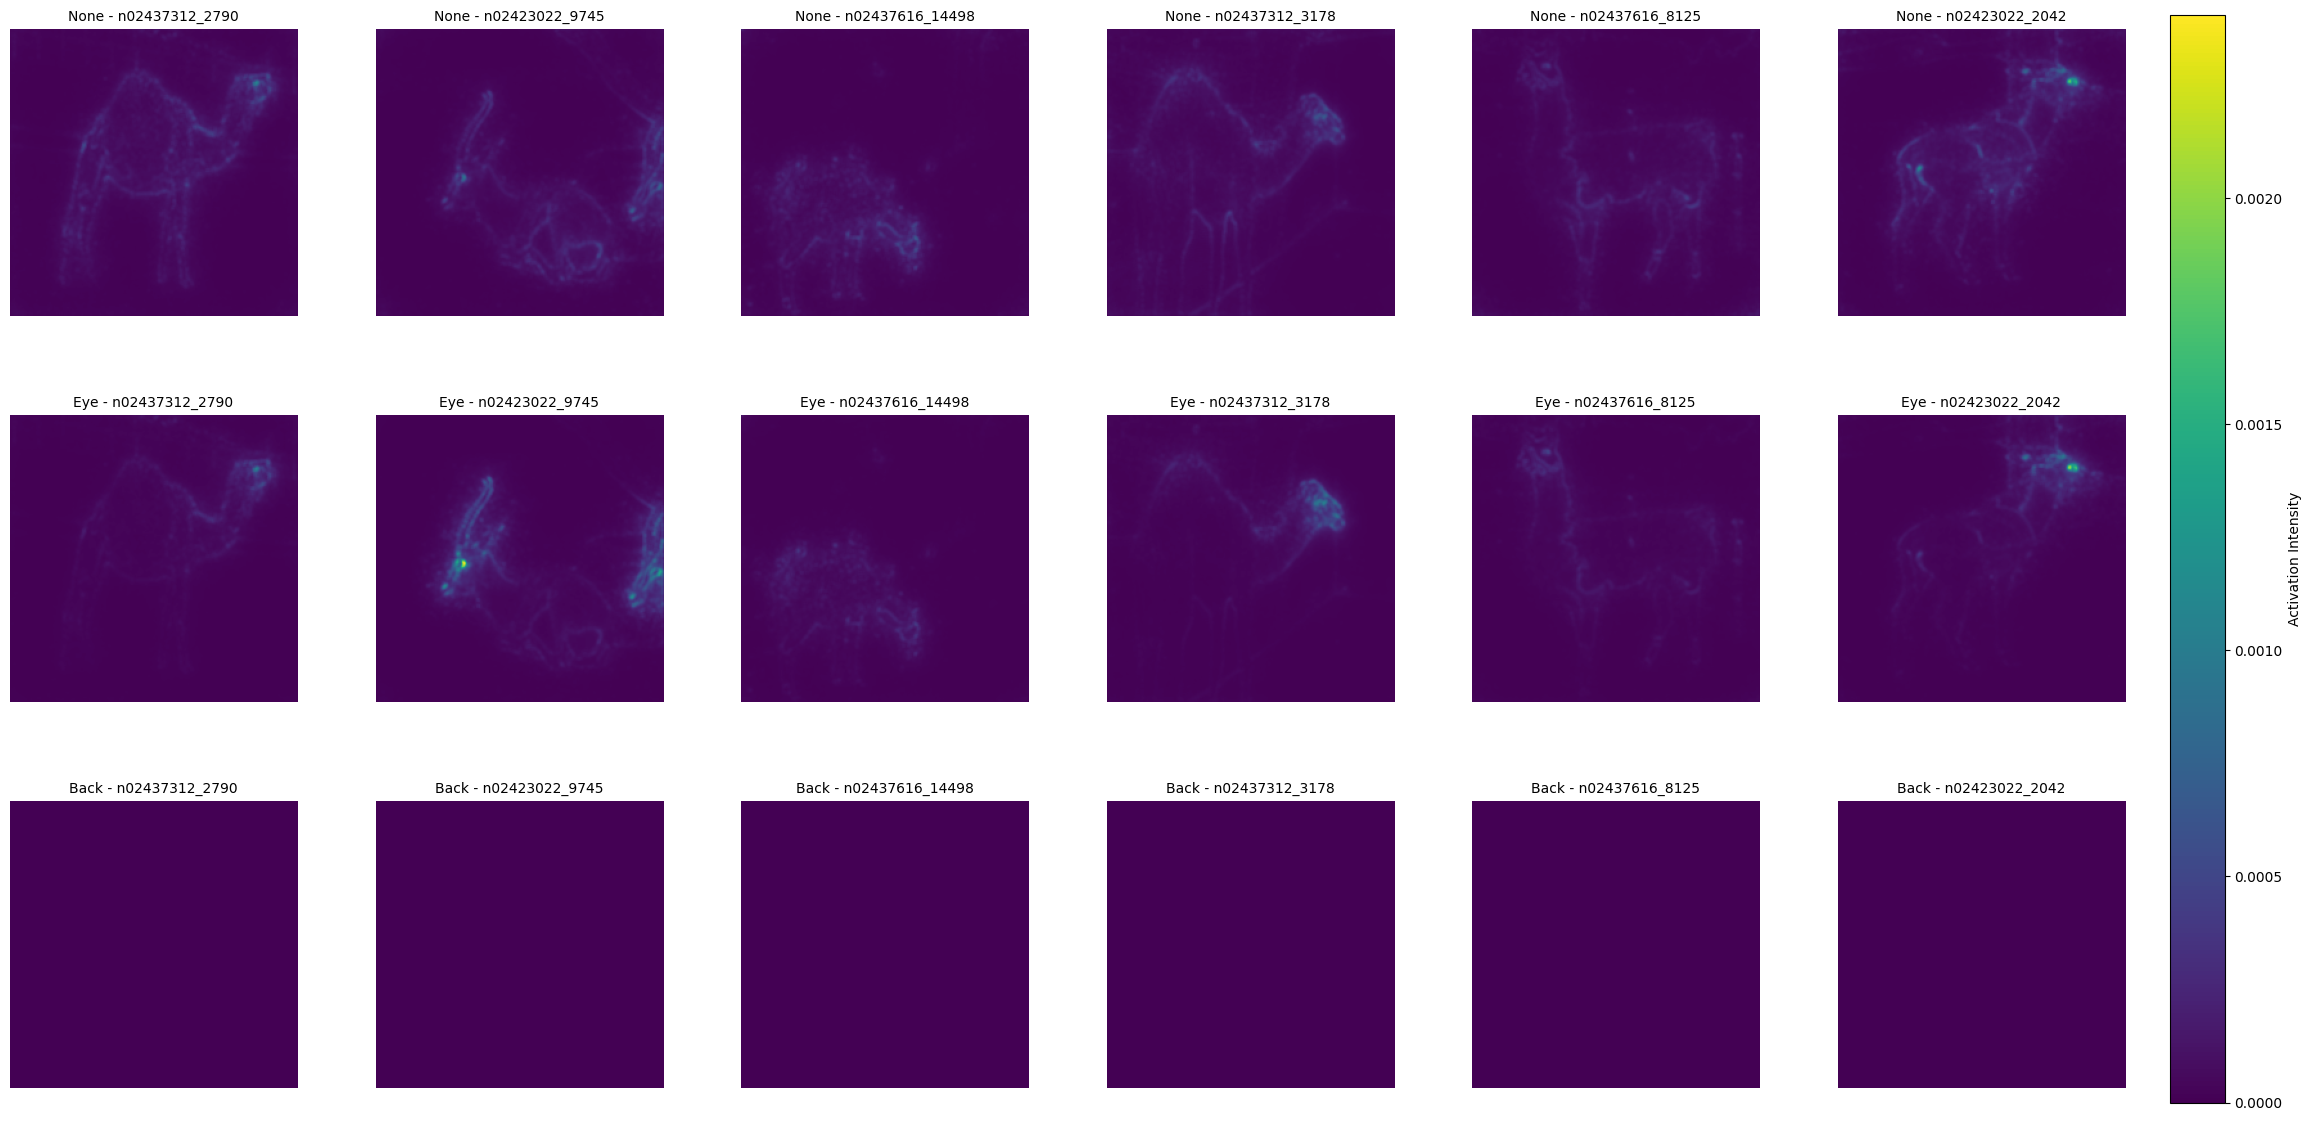

In [137]:
visualize_clusters(cluster_analysis_file_to_use, base_path, target_occurence_min_per_class, list_image_name_to_test)